## 用逻辑回归制作评分卡　　
**问题**:在银行借贷场景中，评分卡是一种以分数形式来衡量一个客户的信用风险大小的手段，它衡量向别人借钱的人（受
信人，需要融资的公司）不能如期履行合同中的还本付息责任，并让借钱给别人的人（授信人，银行等金融机构）
造成经济损失的可能性。一般来说，评分卡打出的分数越高，客户的信用越好，风险越小。
这些”借钱的人“，可能是个人，有可能是有需求的公司和企业。对于企业来说，我们按照融资主体的融资用途，分
别使用企业融资模型，现金流融资模型，项目融资模型等模型。而对于个人来说，我们有”四张卡“来评判个人的信
用程度：A卡，B卡，C卡和F卡。而众人常说的“评分卡”其实是指A卡，又称为申请者评级模型，主要应用于相关融
资类业务中新用户的主体评级，即判断金融机构是否应该借钱给一个新用户，如果这个人的风险太高，我们可以拒
绝贷款。

### 获取数据

In [20]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [21]:
df = pd.read_csv("./data/rankingcard.csv", index_col=0)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


In [23]:
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


### 数据清洗

#### 消除重复项　　
**目的：**数据极大可能不会存在两个相同的数据

In [24]:
df.drop_duplicates(inplace=True)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149391 entries, 1 to 150000
Data columns (total 11 columns):
SeriousDlqin2yrs                        149391 non-null int64
RevolvingUtilizationOfUnsecuredLines    149391 non-null float64
age                                     149391 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    149391 non-null int64
DebtRatio                               149391 non-null float64
MonthlyIncome                           120170 non-null float64
NumberOfOpenCreditLinesAndLoans         149391 non-null int64
NumberOfTimes90DaysLate                 149391 non-null int64
NumberRealEstateLoansOrLines            149391 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    149391 non-null int64
NumberOfDependents                      145563 non-null float64
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


In [26]:
# 恢复索引值
df.index = range(df.shape[0])

#### 探索缺失值　
**目的：**探索数据中的缺失值，查看数据缺失部分的信息对整体的影响

In [27]:
# 统计特征的数据缺失情况
df.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29221
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3828
dtype: int64

In [28]:
# 特征缺失比率
df.isnull().sum()/df.shape[0]

SeriousDlqin2yrs                        0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.195601
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.025624
dtype: float64

In [29]:
# 家属人数缺失比率为2.5％，考虑使用均值进行添补
df.NumberOfDependents.fillna(int(df.NumberOfDependents.mean())
                             , inplace=True)

In [30]:
# 对于月收入来说，是衡量一个人信贷信用的重要的一项特征，可以使其他方法进行预测
# 来得到缺失的月收入数据，使用随机森林的方法进行填充
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149391 entries, 0 to 149390
Data columns (total 11 columns):
SeriousDlqin2yrs                        149391 non-null int64
RevolvingUtilizationOfUnsecuredLines    149391 non-null float64
age                                     149391 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    149391 non-null int64
DebtRatio                               149391 non-null float64
MonthlyIncome                           120170 non-null float64
NumberOfOpenCreditLinesAndLoans         149391 non-null int64
NumberOfTimes90DaysLate                 149391 non-null int64
NumberRealEstateLoansOrLines            149391 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    149391 non-null int64
NumberOfDependents                      149391 non-null float64
dtypes: float64(4), int64(7)
memory usage: 12.5 MB


In [31]:
df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,149391.000000,149391.000000,149391.000000,149391.000000,149391.000000,1.201700e+05,149391.000000,149391.000000,149391.000000,149391.000000,149391.000000
mean,0.066999,6.071087,52.306237,0.393886,354.436740,6.675098e+03,8.480892,0.238120,1.022391,0.212503,0.740393
std,0.250021,250.263672,14.725962,3.852953,2041.843455,1.438958e+04,5.136515,3.826165,1.130196,3.810523,1.108272
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.030132,41.000000,0.000000,0.177441,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154235,52.000000,0.000000,0.368234,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.556494,63.000000,0.000000,0.875279,8.250000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [32]:
# 使用随机森林进行数据缺失的添补
def fiil_missing_rf(x, y, to_fill):
    """
    """
    df = x.copy()
    fill = df.loc[:, to_fill] # 获得带填充数据
    df = pd.concat([df.loc[:, df.columns != to_fill], pd.DataFrame(y)], axis=1)
    
    # 划分数据
    Ytrain = fill[fill.notnull()]
    Ytest = fill[fill.isnull()]
    # 根据标签划分数据集
    Xtrain = df.iloc[Ytrain.index, :]
    Xtest = df.iloc[Ytest.index, :]

    # 使用随机森林
    from sklearn.ensemble import RandomForestRegressor as rfr
    rfr = rfr(n_estimators = 100)
    rfr = rfr.fit(Xtrain, Ytrain)
    Y_predict = rfr.predict(Xtest)
    
    return Y_predict

In [33]:
x = df.iloc[:, 1:]
y =  df.SeriousDlqin2yrs

In [34]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149391 entries, 0 to 149390
Data columns (total 10 columns):
RevolvingUtilizationOfUnsecuredLines    149391 non-null float64
age                                     149391 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    149391 non-null int64
DebtRatio                               149391 non-null float64
MonthlyIncome                           120170 non-null float64
NumberOfOpenCreditLinesAndLoans         149391 non-null int64
NumberOfTimes90DaysLate                 149391 non-null int64
NumberRealEstateLoansOrLines            149391 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    149391 non-null int64
NumberOfDependents                      149391 non-null float64
dtypes: float64(4), int64(6)
memory usage: 11.4 MB


In [35]:
y_pred = fiil_missing_rf(x, y, "MonthlyIncome")

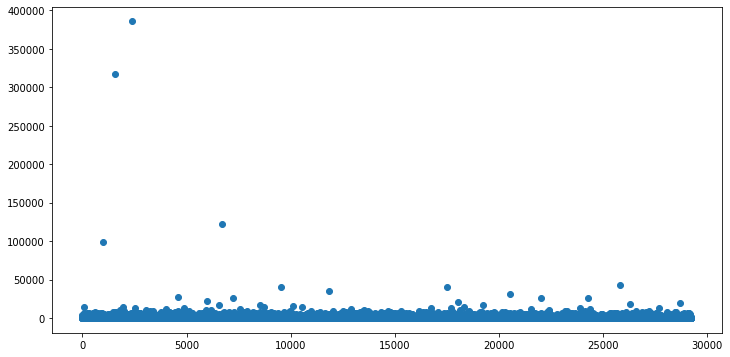

In [36]:
plt.figure(figsize=(12, 6))
plt.scatter(range(0, 29221), y_pred)
plt.show()

In [37]:
# 进行数据填充
df.loc[df.loc[:, "MonthlyIncome"].isnull(), "MonthlyIncome"] = y_pred

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149391 entries, 0 to 149390
Data columns (total 11 columns):
SeriousDlqin2yrs                        149391 non-null int64
RevolvingUtilizationOfUnsecuredLines    149391 non-null float64
age                                     149391 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    149391 non-null int64
DebtRatio                               149391 non-null float64
MonthlyIncome                           149391 non-null float64
NumberOfOpenCreditLinesAndLoans         149391 non-null int64
NumberOfTimes90DaysLate                 149391 non-null int64
NumberRealEstateLoansOrLines            149391 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    149391 non-null int64
NumberOfDependents                      149391 non-null float64
dtypes: float64(4), int64(7)
memory usage: 12.5 MB


#### 异常值的处理
**目的：**现实数据中总会有一些异常值，观察异常值有助于我们更好理解一些特殊情况下的数据问题

In [39]:
df.describe([0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
SeriousDlqin2yrs,149391.0,0.066999,0.250021,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
RevolvingUtilizationOfUnsecuredLines,149391.0,6.071087,250.263672,0.0,0.0,0.003199,0.030132,0.154235,0.556494,0.978007,1.093922,50708.0
age,149391.0,52.306237,14.725962,0.0,24.0,33.000000,41.000000,52.000000,63.000000,72.000000,87.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,149391.0,0.393886,3.852953,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,98.0
DebtRatio,149391.0,354.436740,2041.843455,0.0,0.0,0.034991,0.177441,0.368234,0.875279,1275.000000,4985.100000,329664.0
MonthlyIncome,149391.0,5424.299109,13232.268582,0.0,0.0,0.180000,1800.000000,4420.000000,7416.000000,10800.000000,23250.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,149391.0,8.480892,5.136515,0.0,0.0,3.000000,5.000000,8.000000,11.000000,15.000000,24.000000,58.0
NumberOfTimes90DaysLate,149391.0,0.238120,3.826165,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,98.0
NumberRealEstateLoansOrLines,149391.0,1.022391,1.130196,0.0,0.0,0.000000,0.000000,1.000000,2.000000,2.000000,4.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,149391.0,0.212503,3.810523,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,98.0


In [40]:
# 异常值年龄的问题，最小值为0银行不可能给开户
(df.age == 0).sum()

1

In [41]:
df = df[df.age != 0]
df.age.describe()

count    149390.000000
mean         52.306587
std          14.725390
min          21.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64

In [42]:
# 探索逾期拖欠人员的数据
df[df.loc[:,"NumberOfTimes90DaysLate"]>90].count()

SeriousDlqin2yrs                        225
RevolvingUtilizationOfUnsecuredLines    225
age                                     225
NumberOfTime30-59DaysPastDueNotWorse    225
DebtRatio                               225
MonthlyIncome                           225
NumberOfOpenCreditLinesAndLoans         225
NumberOfTimes90DaysLate                 225
NumberRealEstateLoansOrLines            225
NumberOfTime60-89DaysPastDueNotWorse    225
NumberOfDependents                      225
dtype: int64

In [43]:
# 观察拖欠人员的数据
df = df[df.loc[:, "NumberOfTimes90DaysLate"]<90]

In [44]:
df.index = range(df.shape[0])

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149165 entries, 0 to 149164
Data columns (total 11 columns):
SeriousDlqin2yrs                        149165 non-null int64
RevolvingUtilizationOfUnsecuredLines    149165 non-null float64
age                                     149165 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    149165 non-null int64
DebtRatio                               149165 non-null float64
MonthlyIncome                           149165 non-null float64
NumberOfOpenCreditLinesAndLoans         149165 non-null int64
NumberOfTimes90DaysLate                 149165 non-null int64
NumberRealEstateLoansOrLines            149165 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    149165 non-null int64
NumberOfDependents                      149165 non-null float64
dtypes: float64(4), int64(7)
memory usage: 12.5 MB


#### 样本不均衡的问题

In [46]:
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [47]:
y = df.iloc[:, 0]
x = df.iloc[:, 1:]

In [48]:
x.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [49]:
y.head()

0    1
1    0
2    0
3    0
4    0
Name: SeriousDlqin2yrs, dtype: int64

In [50]:
# 好坏样本比例不平衡
y.value_counts()

0    139292
1      9873
Name: SeriousDlqin2yrs, dtype: int64

In [51]:
n_samples = x.shape[0]
n_samples

149165

In [52]:
n0_samples = y.value_counts()[0]/n_samples
n1_samples = y.value_counts()[1]/n_samples
print("n0_samples :{}\nn1_samples :{}".format(n0_samples, n1_samples))

n0_samples :0.9338115509670499
n1_samples :0.06618844903295008


In [53]:
# 使用数据包imblearn
from imblearn.over_sampling import  SMOTE

sm = SMOTE(random_state=10)

X, y = sm.fit_sample(x, y)

In [54]:
y.value_counts()

1    139292
0    139292
Name: SeriousDlqin2yrs, dtype: int64

In [55]:
n_samples_ = X.shape[0]

In [56]:
n0_samples = y.value_counts()[0]/n_samples_
n1_samples = y.value_counts()[1]/n_samples_
print("n0_samples :{}\nn1_samples :{}".format(n0_samples, n1_samples))

n0_samples :0.5
n1_samples :0.5


In [57]:
X

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.766127,45,2,0.802982,9120.000000,13,0,6,0,2.000000
1,0.957151,40,0,0.121876,2600.000000,4,0,0,0,1.000000
2,0.658180,38,1,0.085113,3042.000000,2,1,0,0,0.000000
3,0.233810,30,0,0.036050,3300.000000,5,0,0,0,0.000000
4,0.907239,49,1,0.024926,63588.000000,7,0,1,0,0.000000
...,...,...,...,...,...,...,...,...,...,...
278579,0.881146,54,1,0.284614,6000.000000,4,0,1,0,0.719704
278580,1.830333,41,2,0.361350,2413.421229,6,4,0,1,1.822346
278581,1.000000,37,1,1.009745,1500.000000,3,0,0,0,2.544875
278582,0.948814,28,0,0.262907,964.114045,3,0,0,0,0.685674


#### 存储数据清洗的结果 

In [58]:
from sklearn.model_selection import train_test_split
x = pd.DataFrame(X)
y = pd.DataFrame(y)


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

# 模型数据
model_date = pd.concat([y_train, x_train], axis=1)
model_date.index = range(0, model_date.shape[0])
model_date.columns = df.columns

#　验证集数据
valid_data = pd.concat([y_test, x_test], axis=1)
valid_data.index = range(valid_data.shape[0])
valid_data.columns = df.columns

model_date.to_csv("./data/model_data.csv")
valid_data.to_csv("./data/valid_data.csv")

In [59]:
model_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195008 entries, 0 to 195007
Data columns (total 11 columns):
SeriousDlqin2yrs                        195008 non-null int64
RevolvingUtilizationOfUnsecuredLines    195008 non-null float64
age                                     195008 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    195008 non-null int64
DebtRatio                               195008 non-null float64
MonthlyIncome                           195008 non-null float64
NumberOfOpenCreditLinesAndLoans         195008 non-null int64
NumberOfTimes90DaysLate                 195008 non-null int64
NumberRealEstateLoansOrLines            195008 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    195008 non-null int64
NumberOfDependents                      195008 non-null float64
dtypes: float64(4), int64(7)
memory usage: 16.4 MB


In [60]:
valid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83576 entries, 0 to 83575
Data columns (total 11 columns):
SeriousDlqin2yrs                        83576 non-null int64
RevolvingUtilizationOfUnsecuredLines    83576 non-null float64
age                                     83576 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    83576 non-null int64
DebtRatio                               83576 non-null float64
MonthlyIncome                           83576 non-null float64
NumberOfOpenCreditLinesAndLoans         83576 non-null int64
NumberOfTimes90DaysLate                 83576 non-null int64
NumberRealEstateLoansOrLines            83576 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    83576 non-null int64
NumberOfDependents                      83576 non-null float64
dtypes: float64(4), int64(7)
memory usage: 7.0 MB


#### 分箱

In [61]:
# 等频分箱
model_date["qcut"], updown = pd.qcut(model_date.age, q=20, retbins=True)

In [62]:
# 新增每一个样本所属于的分箱区间
model_date.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,qcut
0,0,0.053341,38,0,0.390255,6669.000000,11,0,2,0,3.000000,"(36.0, 39.0]"
1,0,0.000000,50,3,0.075698,4583.000000,5,0,0,0,2.000000,"(48.0, 50.0]"
2,0,0.052746,60,0,0.050895,10000.000000,5,0,1,0,1.000000,"(58.0, 61.0]"
3,0,0.088999,42,0,0.445977,7320.000000,15,2,1,0,5.000000,"(41.0, 43.0]"
4,1,0.995736,52,0,0.243322,7787.185293,1,0,0,0,0.962941,"(50.0, 52.0]"


In [63]:
# 分箱上限
updown

array([ 21.,  28.,  31.,  34.,  36.,  39.,  41.,  43.,  45.,  46.,  48.,
        50.,  52.,  54.,  56.,  58.,  61.,  64.,  68.,  74., 109.])

In [64]:
model_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195008 entries, 0 to 195007
Data columns (total 12 columns):
SeriousDlqin2yrs                        195008 non-null int64
RevolvingUtilizationOfUnsecuredLines    195008 non-null float64
age                                     195008 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    195008 non-null int64
DebtRatio                               195008 non-null float64
MonthlyIncome                           195008 non-null float64
NumberOfOpenCreditLinesAndLoans         195008 non-null int64
NumberOfTimes90DaysLate                 195008 non-null int64
NumberRealEstateLoansOrLines            195008 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    195008 non-null int64
NumberOfDependents                      195008 non-null float64
qcut                                    195008 non-null category
dtypes: category(1), float64(4), int64(7)
memory usage: 16.6 MB


In [65]:
coount_y0 = model_date[model_date.SeriousDlqin2yrs == 0].groupby("qcut").count().SeriousDlqin2yrs

In [66]:
coount_y0

qcut
(20.999, 28.0]    4244
(28.0, 31.0]      3552
(31.0, 34.0]      4001
(34.0, 36.0]      2923
(36.0, 39.0]      5197
(39.0, 41.0]      3939
(41.0, 43.0]      4039
(43.0, 45.0]      4400
(45.0, 46.0]      2398
(46.0, 48.0]      4803
(48.0, 50.0]      4896
(50.0, 52.0]      4631
(52.0, 54.0]      4671
(54.0, 56.0]      4515
(56.0, 58.0]      4531
(58.0, 61.0]      6706
(61.0, 64.0]      6948
(64.0, 68.0]      6623
(68.0, 74.0]      6831
(74.0, 109.0]     7766
Name: SeriousDlqin2yrs, dtype: int64

In [67]:
coount_y1 = model_date[model_date.SeriousDlqin2yrs == 1].groupby("qcut").count().SeriousDlqin2yrs

In [68]:
coount_y1

qcut
(20.999, 28.0]    7440
(28.0, 31.0]      5923
(31.0, 34.0]      6760
(34.0, 36.0]      4727
(36.0, 39.0]      7604
(39.0, 41.0]      5922
(41.0, 43.0]      5617
(43.0, 45.0]      5826
(45.0, 46.0]      3311
(46.0, 48.0]      6225
(48.0, 50.0]      6271
(50.0, 52.0]      5661
(52.0, 54.0]      4718
(54.0, 56.0]      4191
(56.0, 58.0]      3550
(58.0, 61.0]      4794
(61.0, 64.0]      3277
(64.0, 68.0]      2327
(68.0, 74.0]      1904
(74.0, 109.0]     1346
Name: SeriousDlqin2yrs, dtype: int64

In [69]:
# 计算每一个区间的0和1的个数
num_bins = [*zip(updown, updown[1:], coount_y0, coount_y1)]

In [70]:
num_bins

[(21.0, 28.0, 4244, 7440),
 (28.0, 31.0, 3552, 5923),
 (31.0, 34.0, 4001, 6760),
 (34.0, 36.0, 2923, 4727),
 (36.0, 39.0, 5197, 7604),
 (39.0, 41.0, 3939, 5922),
 (41.0, 43.0, 4039, 5617),
 (43.0, 45.0, 4400, 5826),
 (45.0, 46.0, 2398, 3311),
 (46.0, 48.0, 4803, 6225),
 (48.0, 50.0, 4896, 6271),
 (50.0, 52.0, 4631, 5661),
 (52.0, 54.0, 4671, 4718),
 (54.0, 56.0, 4515, 4191),
 (56.0, 58.0, 4531, 3550),
 (58.0, 61.0, 6706, 4794),
 (61.0, 64.0, 6948, 3277),
 (64.0, 68.0, 6623, 2327),
 (68.0, 74.0, 6831, 1904),
 (74.0, 109.0, 7766, 1346)]

In [71]:
def get_woe(num_bins):
    
    columns = ["min", "max", "count_0", "count_1"]
    df  = pd.DataFrame(num_bins, columns=columns)

    df["total"] = df.count_0 + df.count_1
    df["percentage"] = df.total/df.total.sum()
    df["bad_rate"] = df.count_1/df.total

    df["good%"] = df.count_0/df.count_0.sum()
    df["bad%"] = df.count_1/df.count_1.sum()
    df["woe"] = np.log(df["good%"]/df["bad%"])
    
    return df

In [72]:
def get_iv(df):
    rate = df["good%"] - df["bad%"]
    iv = np.sum(rate*df.woe)
    return iv

In [73]:
num_bins_ = num_bins.copy()
df = get_woe(num_bins_)
iv = get_iv(df)

In [74]:
# 对年龄值进行分箱之后的操作
iv

0.35767477827896665

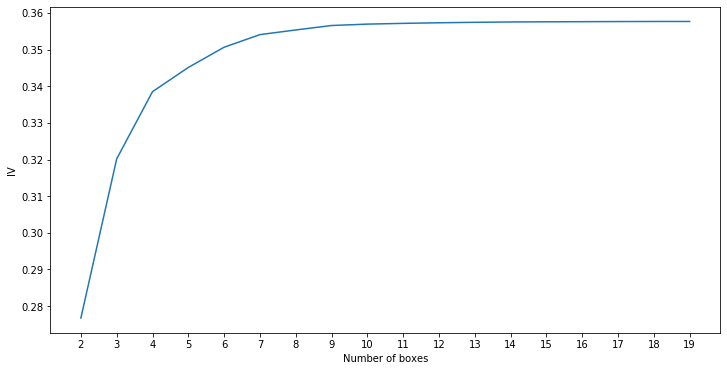

In [75]:
IV = [] # 存贮iv值
axisx = [] # 存储不同的分箱个数

while len(num_bins_)>2:
    pvs = []
    
    # 计算相邻两个区间的卡方检验
    for i in range(len(num_bins_)-1):
        x1 = num_bins_[i][2:]
        x2 = num_bins_[i+1][2:]
        
        pv = scipy.stats.chi2_contingency([x1, x2])[1]
        pvs.append(pv)
        
    # 通过计算p值　合并p值最大的两个区间
    i = pvs.index(max(pvs))
    num_bins_[i:i+2] = [(num_bins_[i][0]
                     , num_bins_[i+1][1]
                     , num_bins_[i][2] + num_bins_[i+1][2]
                     , num_bins_[i][3] + num_bins_[i+1][3])]
    
    bins_df = get_woe(num_bins_)
    axisx.append(len(num_bins_))
    IV.append(get_iv(bins_df))
    
plt.figure(figsize=(12, 6))
plt.plot(axisx, IV)
plt.xlabel("Number of boxes")
plt.ylabel("IV")
plt.xticks(axisx)
plt.show()      

In [76]:
# 封装成新的函数
def graphforbestbin(DF, X, Y, n=5, q=20, graph = True):
    """自动分箱函数"""
    
    DF = DF[[X, Y]].copy()
    
    DF["qcut"], bins = pd.qcut(DF[X], retbins=True, q=q, duplicates="drop")
    coount_y0 = DF.loc[DF[Y] == 0].groupby(by="qcut").count()[Y]
    coount_y1 = DF.loc[DF[Y] == 1].groupby(by="qcut").count()[Y]
    num_bins = [*zip(bins, bins[1:], coount_y0, coount_y1)]

# 消除零的存在    
    for i in range(q):
        if 0 in num_bins[0][2:]:
            num_bins[0:2] = [(
                num_bins[0][0],
                num_bins[1][1],
                num_bins[0][2] + num_bins[1][2],
                num_bins[0][3] + num_bins[1][3]
            )]
            continue
            
    for i in range(len(num_bins)):
        if 0 in num_bins[i][2:]:
            num_bins[i-1:i+1] = [(
                num_bins[i-1][0],
                num_bins[i][1],
                num_bins[i-1][2] + num_bins[i][2],
                num_bins[i-1][3] + num_bins[i][3]
            )]
            break
        else:
            break  
    
    def get_woe(num_bins):
    
        columns = ["min", "max", "count_0", "count_1"]
        df  = pd.DataFrame(num_bins, columns=columns)

        df["total"] = df.count_0 + df.count_1
        df["percentage"] = df.total/df.total.sum()
        df["bad_rate"] = df.count_1/df.total

        df["good%"] = df.count_0/df.count_0.sum()
        df["bad%"] = df.count_1/df.count_1.sum()
        df["woe"] = np.log(df["good%"]/df["bad%"])

        return df
    
    def get_iv(df):
        rate = df["good%"] - df["bad%"]
        iv = np.sum(rate*df.woe)
        return iv

    IV = []
    axisx = []

    while len(num_bins) > n:
        pvs = []

        # 计算相邻两个区间的卡方检验
        for i in range(len(num_bins)-1):
            x1 = num_bins[i][2:]
            x2 = num_bins[i+1][2:]

            pv = scipy.stats.chi2_contingency([x1, x2])[1]
            pvs.append(pv)

        # 通过计算p值　合并p值最大的两个区间
        i = pvs.index(max(pvs))
        num_bins[i:i+2] = [(num_bins[i][0]
                         , num_bins[i+1][1]
                         , num_bins[i][2] + num_bins[i+1][2]
                         , num_bins[i][3] + num_bins[i+1][3])]
        global bins_df
        bins_df = pd.DataFrame(get_woe(num_bins))
        axisx.append(len(num_bins))
        IV.append(get_iv(bins_df))
        
    if graph:
        plt.figure(figsize=(12, 6))
        plt.plot(axisx, IV)
        plt.xlabel("Number of boxes")
        plt.ylabel("IV")
        plt.xticks(axisx)
        plt.show()    
    return bins_df

Feature:RevolvingUtilizationOfUnsecuredLines


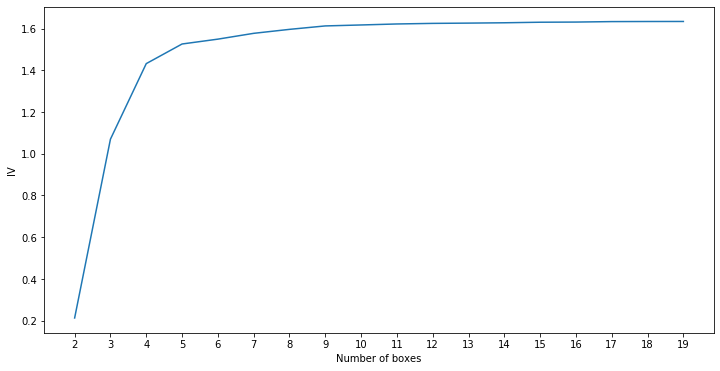

Feature:age


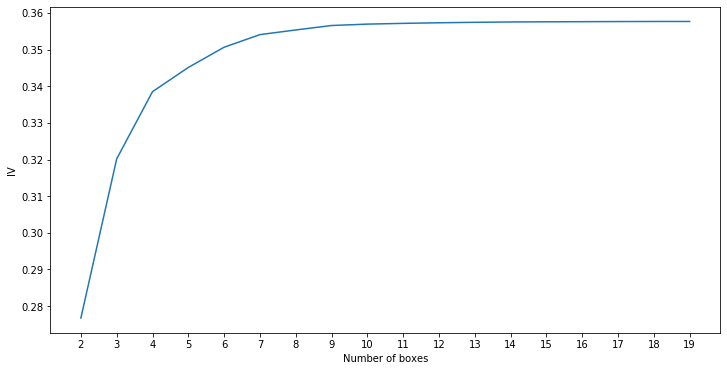

Feature:NumberOfTime30-59DaysPastDueNotWorse


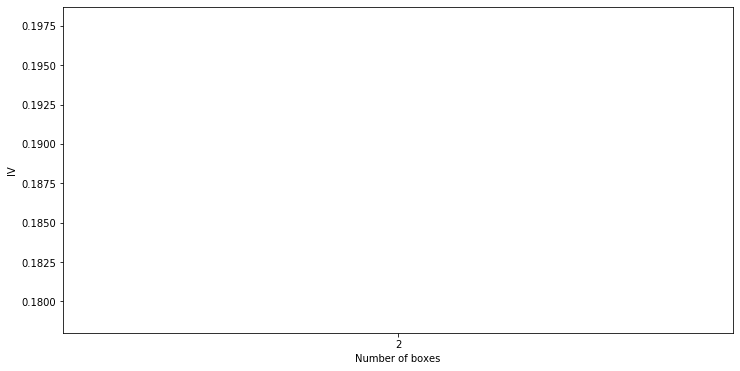

Feature:DebtRatio


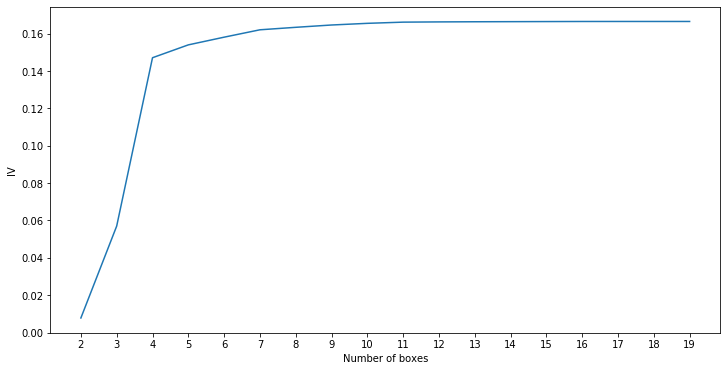

Feature:MonthlyIncome


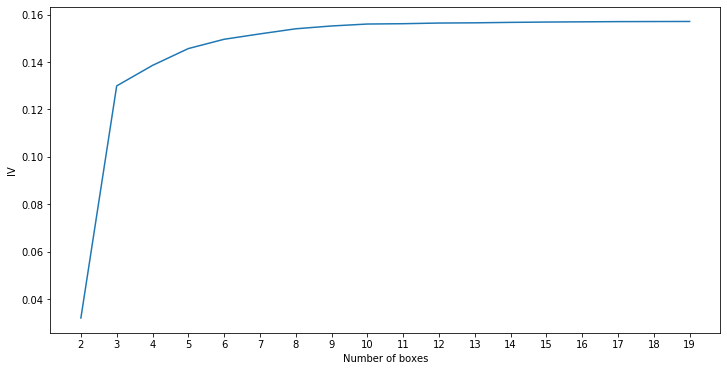

Feature:NumberOfOpenCreditLinesAndLoans


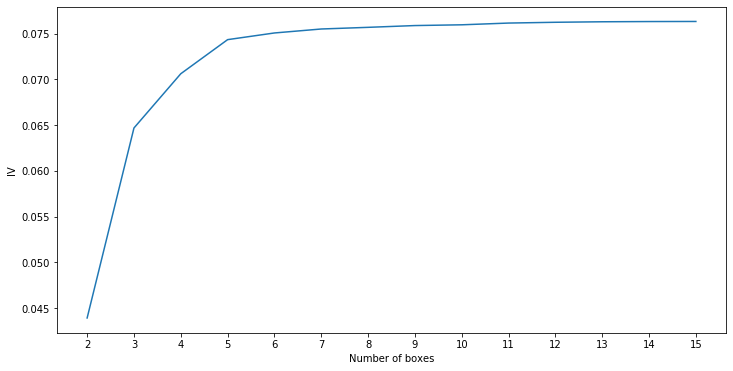

Feature:NumberOfTimes90DaysLate


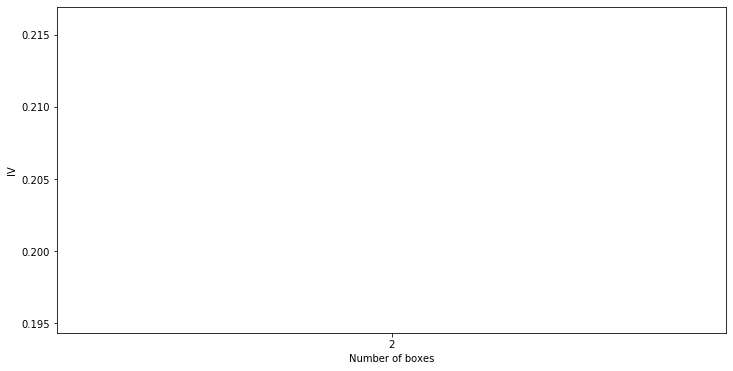

Feature:NumberRealEstateLoansOrLines


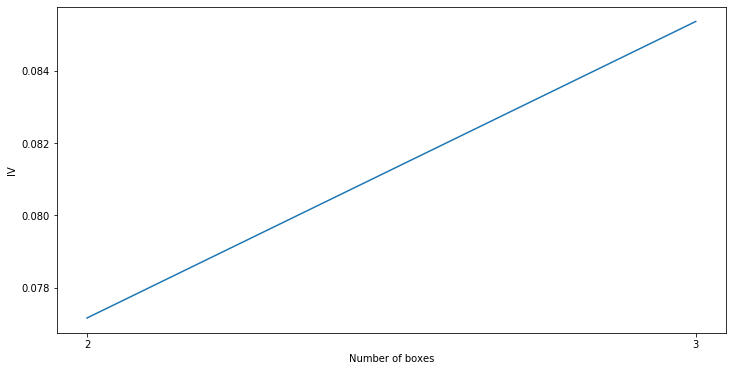

Feature:NumberOfTime60-89DaysPastDueNotWorse


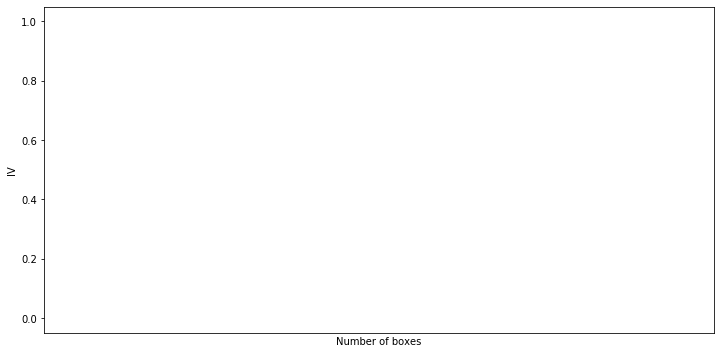

In [77]:
for i in model_date.columns[1:-2]:
    print("Feature:{}".format(i))
    graphforbestbin(model_date, i, "SeriousDlqin2yrs", n=2, q=20)

In [78]:
model_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195008 entries, 0 to 195007
Data columns (total 12 columns):
SeriousDlqin2yrs                        195008 non-null int64
RevolvingUtilizationOfUnsecuredLines    195008 non-null float64
age                                     195008 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    195008 non-null int64
DebtRatio                               195008 non-null float64
MonthlyIncome                           195008 non-null float64
NumberOfOpenCreditLinesAndLoans         195008 non-null int64
NumberOfTimes90DaysLate                 195008 non-null int64
NumberRealEstateLoansOrLines            195008 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    195008 non-null int64
NumberOfDependents                      195008 non-null float64
qcut                                    195008 non-null category
dtypes: category(1), float64(4), int64(7)
memory usage: 16.6 MB


In [80]:
auto_col_bins = {
    "RevolvingUtilizationOfUnsecuredLines":6,
    "age":5,
    "DebtRatio":3,
    "NumberOfOpenCreditLinesAndLoans":5
}

# 不能使用自动分箱的特征
hand_bins = {
    "NumberOfTime30-59DaysPastDueNotWorse":[0, 1, 2, 13],
    "NumberOfTimes90DaysLate":[0, 1, 2, 17],
    "NumberRealEstateLoansOrLines":[0, 1, 2, 4, 54],
    "NumberOfTime60-89DaysPastDueNotWorse":[0, 1, 2, 8],
    "NumberOfDependents":[0, 1, 2, 3]
}

In [81]:
auto_col_bins

{'RevolvingUtilizationOfUnsecuredLines': 6,
 'age': 5,
 'DebtRatio': 3,
 'NumberOfOpenCreditLinesAndLoans': 5}

In [82]:
hand_bins

{'NumberOfTime30-59DaysPastDueNotWorse': [0, 1, 2, 13],
 'NumberOfTimes90DaysLate': [0, 1, 2, 17],
 'NumberRealEstateLoansOrLines': [0, 1, 2, 4, 54],
 'NumberOfTime60-89DaysPastDueNotWorse': [0, 1, 2, 8],
 'NumberOfDependents': [0, 1, 2, 3]}

In [83]:
hand_bins = {k: [-np.inf, *v[:-1], np.inf] for k, v in hand_bins.items()}

In [84]:
hand_bins

{'NumberOfTime30-59DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfTimes90DaysLate': [-inf, 0, 1, 2, inf],
 'NumberRealEstateLoansOrLines': [-inf, 0, 1, 2, 4, inf],
 'NumberOfTime60-89DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfDependents': [-inf, 0, 1, 2, inf]}

In [88]:
bins_of_col = {}

for col in auto_col_bins:
    bins_df = graphforbestbin(model_date, col
                              , "SeriousDlqin2yrs"
                              , n = auto_col_bins[col]
                              , q=20
                              , graph=False
                             )
#     print(bins_df)
    bins_list = sorted(set(bins_df["min"]).union(bins_df["max"]))
    bins_list[0], bins_list[-1] = -np.inf, np.inf
    bins_of_col[col] = bins_list

In [92]:
bins_of_col

{'RevolvingUtilizationOfUnsecuredLines': [-inf,
  0.0606593968,
  0.1532245132340173,
  0.4653877839237632,
  0.9828437174280079,
  0.9999998999999999,
  inf],
 'age': [-inf, 41.0, 52.0, 61.0, 74.0, inf],
 'DebtRatio': [-inf, 0.5026755106, 1.4096512734000008, inf],
 'NumberOfOpenCreditLinesAndLoans': [-inf, 1.0, 3.0, 5.0, 17.0, inf]}

In [191]:
bins_of_col.update(hand_bins)

In [192]:
bins_of_col

{'RevolvingUtilizationOfUnsecuredLines': [-inf,
  0.06021171880000001,
  0.2972229201018362,
  0.6384587203928881,
  0.9829659117418209,
  0.9999998999999999,
  inf],
 'age': [-inf, 41.0, 52.0, 61.0, 74.0, inf],
 'DebtRatio': [-inf, 0.5042922621671139, 1.4447234706000007, inf],
 'NumberOfOpenCreditLinesAndLoans': [-inf, 1.0, 3.0, 5.0, 17.0, inf],
 'NumberOfTime30-59DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfTimes90DaysLate': [-inf, 0, 1, 2, inf],
 'NumberRealEstateLoansOrLines': [-inf, 0, 1, 2, 4, inf],
 'NumberOfTime60-89DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfDependents': [-inf, 0, 1, 2, inf]}

In [93]:
# 映射数据
data = model_date.copy()
data = data[["age", "SeriousDlqin2yrs"]].copy()

In [94]:
# 分箱
data["cut"] = pd.cut(data.age, [-np.inf, 48, 58, 64, 74, np.inf])
data.groupby(by="cut")["SeriousDlqin2yrs"].value_counts()

cut           SeriousDlqin2yrs
(-inf, 48.0]  1                   59355
              0                   39496
(48.0, 58.0]  1                   24391
              0                   23244
(58.0, 64.0]  0                   13654
              1                    8071
(64.0, 74.0]  0                   13454
              1                    4231
(74.0, inf]   0                    7766
              1                    1346
Name: SeriousDlqin2yrs, dtype: int64

In [95]:
# 将树状结构变为表状结构
bins_df = data.groupby(by="cut")["SeriousDlqin2yrs"].value_counts().unstack()

In [96]:
bins_df["woe"] = np.log((bins_df[0]/bins_df[0].sum())/ (bins_df[1]/bins_df[1].sum()))

In [97]:
bins_df

SeriousDlqin2yrs,0,1,woe
cut,,,
"(-inf, 48.0]",39496,59355,-0.409593
"(48.0, 58.0]",23244,24391,-0.050423
"(58.0, 64.0]",13654,8071,0.523499
"(64.0, 74.0]",13454,4231,1.154582
"(74.0, inf]",7766,1346,1.750362


In [98]:
# 封装函数
def get_woe(df, col, y, bins):
    df = df[[col, y]].copy()
    df["cut"] = pd.cut(df[col], bins)
    bins_df = df.groupby("cut")[y].value_counts().unstack()
#     print(bins_df)
    woe = bins_df["woe"] = np.log((bins_df[0]/bins_df[0].sum())/ (bins_df[1]/bins_df[1].sum()))
    
    return woe

woeall={}
for col in bins_of_col:
    # 计算所有的特征的的woe值
    woeall[col] = get_woe(model_date, col, "SeriousDlqin2yrs", bins_of_col[col])
    

In [99]:
woeall

{'RevolvingUtilizationOfUnsecuredLines': cut
 (-inf, 0.0607]     2.430431
 (0.0607, 0.153]    1.273666
 (0.153, 0.465]     0.173730
 (0.465, 0.983]    -1.064856
 (0.983, 1.0]      -0.492445
 (1.0, inf]        -2.026625
 dtype: float64, 'age': cut
 (-inf, 41.0]   -0.477653
 (41.0, 52.0]   -0.270530
 (52.0, 61.0]    0.166419
 (61.0, 74.0]    0.997407
 (74.0, inf]     1.750362
 dtype: float64, 'DebtRatio': cut
 (-inf, 0.503]    0.097977
 (0.503, 1.41]   -0.478915
 (1.41, inf]      0.176879
 dtype: float64, 'NumberOfOpenCreditLinesAndLoans': cut
 (-inf, 1.0]   -0.850142
 (1.0, 3.0]    -0.349948
 (3.0, 5.0]    -0.061170
 (5.0, 17.0]    0.133225
 (17.0, inf]    0.429936
 dtype: float64}

In [100]:
# 映射到原始数据
model_woe = pd.DataFrame(index=model_date.index)
model_woe

""
0
1
2
3
4
...
195003
195004
195005
195006


In [105]:
woeall["age"]

cut
(-inf, 41.0]   -0.477653
(41.0, 52.0]   -0.270530
(52.0, 61.0]    0.166419
(61.0, 74.0]    0.997407
(74.0, inf]     1.750362
dtype: float64

In [103]:
model_woe["age"] = pd.cut(model_date.age, bins_of_col["age"]).map(woeall["age"])

In [104]:
model_woe

,age
0,"(-inf, 41.0]"
1,"(41.0, 52.0]"
2,"(52.0, 61.0]"
3,"(41.0, 52.0]"
4,"(41.0, 52.0]"
...,...
195003,"(52.0, 61.0]"
195004,"(-inf, 41.0]"
195005,"(41.0, 52.0]"
195006,"(41.0, 52.0]"


In [106]:
# 计算每一维度特征映射后的的woe值
for col in bins_of_col:
    model_woe[col] = pd.cut(model_date[col], bins_of_col[col]).map(woeall[col])

In [107]:
model_woe["SeriousDlqin2yrs"] = model_date.SeriousDlqin2yrs

In [108]:
model_woe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195008 entries, 0 to 195007
Data columns (total 5 columns):
age                                     195008 non-null category
RevolvingUtilizationOfUnsecuredLines    195008 non-null category
DebtRatio                               195008 non-null category
NumberOfOpenCreditLinesAndLoans         195008 non-null category
SeriousDlqin2yrs                        195008 non-null int64
dtypes: category(4), int64(1)
memory usage: 2.2 MB


In [110]:
model_woe.head()

,age,RevolvingUtilizationOfUnsecuredLines,DebtRatio,NumberOfOpenCreditLinesAndLoans,SeriousDlqin2yrs
0,-0.477653,2.430431,0.097977,0.133225,0
1,-0.270530,2.430431,0.097977,-0.061170,0
2,0.166419,2.430431,0.097977,-0.061170,0
3,-0.270530,1.273666,0.097977,0.133225,0
4,-0.270530,-0.492445,0.097977,-0.850142,1


#### 建立模型与验证

In [111]:
# 处理测试集
valid_woe = pd.DataFrame(valid_data.index)

for col in bins_of_col:
    valid_woe[col] = pd.cut(valid_data[col], bins_of_col[col]).map(woeall[col])
valid_woe["SeriousDlqin2yrs"] = valid_data["SeriousDlqin2yrs"]

In [112]:
# 划分验证集合
valid_x = valid_woe.iloc[:, 1:-1]
valid_y = valid_woe.iloc[:, -1]

In [113]:
valid_x.head()

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,NumberOfOpenCreditLinesAndLoans
0,-1.064856,-0.270530,0.097977,-0.349948
1,-0.492445,-0.477653,0.097977,-0.850142
2,0.173730,0.997407,0.176879,-0.061170
3,-0.492445,-0.270530,0.176879,-0.850142
4,-0.492445,-0.270530,0.176879,-0.061170


In [114]:
model_woe.head()

,age,RevolvingUtilizationOfUnsecuredLines,DebtRatio,NumberOfOpenCreditLinesAndLoans,SeriousDlqin2yrs
0,-0.477653,2.430431,0.097977,0.133225,0
1,-0.270530,2.430431,0.097977,-0.061170,0
2,0.166419,2.430431,0.097977,-0.061170,0
3,-0.270530,1.273666,0.097977,0.133225,0
4,-0.270530,-0.492445,0.097977,-0.850142,1


In [115]:
# 划分训练集合
x = model_woe.iloc[:, :-1]
y = model_woe.iloc[:,-1]

In [116]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195008 entries, 0 to 195007
Data columns (total 4 columns):
age                                     195008 non-null category
RevolvingUtilizationOfUnsecuredLines    195008 non-null category
DebtRatio                               195008 non-null category
NumberOfOpenCreditLinesAndLoans         195008 non-null category
dtypes: category(4)
memory usage: 762.6 KB


In [133]:
from sklearn.linear_model import LogisticRegression as LR

lr = LR().fit(x, y)
lr.score(valid_x, valid_y)

0.7390638460802145

In [124]:
lr.n_iter_

array([4], dtype=int32)

#### 调模型参数

/home/gavin/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/gavin/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/gavin/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/gavin/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


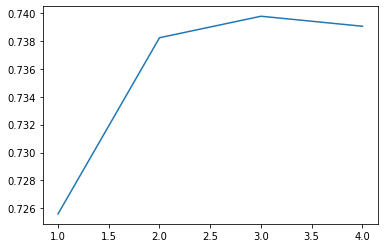

In [125]:
score = []
c = [1, 2, 3, 4]

for i in c:
    lr = LR(solver="liblinear", max_iter=i)
    lr = lr.fit(x, y)
    score.append(lr.score(valid_x, valid_y))
plt.plot(c, score)
plt.show()

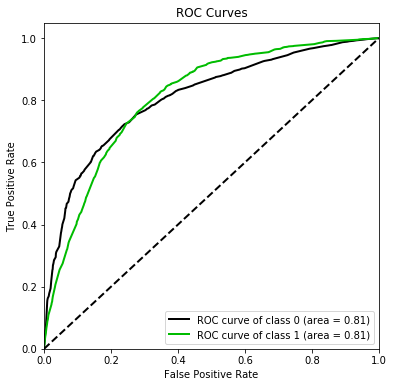

In [134]:
# roc曲线只用于有二分类
import scikitplot as skplt

valid_proba_df = pd.DataFrame(lr.predict_proba(valid_x))
skplt.metrics.plot_roc(valid_y, valid_proba_df, plot_macro=False, figsize=(6, 6), plot_micro=False)

In [257]:
valid_proba_df

,0,1
0,0.596281,0.403719
1,0.650549,0.349451
2,0.838855,0.161145
3,0.787155,0.212845
4,0.093568,0.906432
...,...,...
83571,0.937728,0.062272
83572,0.723241,0.276759
83573,0.799109,0.200891
83574,0.243531,0.756469


In [254]:
valid_y

0        1
1        1
2        0
3        0
4        1
        ..
83571    0
83572    0
83573    0
83574    1
83575    0
Name: SeriousDlqin2yrs, Length: 83576, dtype: int64

#### 制作评分卡

In [270]:
B = 20/np.log(2)
A = 600 + B*np.log(1/60)
B, A

(28.85390081777927, 481.8621880878296)

In [271]:
base_score = A - B*lr.intercept_
base_score

array([481.84259995])

In [272]:
lr.intercept_

array([0.00067887])

In [273]:
score_age = woeall["age"] * (-B*lr.coef_[0][0])
score_age

age
(-inf, 41.0]    -4.029270
(41.0, 52.0]    -2.260533
(52.0, 61.0]     1.399229
(61.0, 74.0]     8.474055
(74.0, inf]     14.460145
dtype: float64

In [274]:
file = "./data/Scoredata.csv"

with open(file, "w") as w:
    w.write("base_score, {}\n".format(base_score))
    

In [275]:
for i, col in enumerate(x.columns):
    score = woeall[col] * (-B*lr.coef_[0][i])
    score.name = "Score"
    score.index.name = col
    score.to_csv(file, header=True, mode="a")

In [276]:
woeall.keys()

dict_keys(['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents'])

In [277]:
lr.coef_

array([[-0.29196343, -0.77307521, -0.81807047, -0.07307574, -0.54478621,
        -0.57677724, -0.99443042, -0.30342185, -0.80425568]])

In [278]:
woeall

{'RevolvingUtilizationOfUnsecuredLines': RevolvingUtilizationOfUnsecuredLines
 (-inf, 0.0602]     2.424213
 (0.0602, 0.297]    0.866847
 (0.297, 0.638]    -0.386680
 (0.638, 0.983]    -1.265651
 (0.983, 1.0]      -0.476094
 (1.0, inf]        -2.050224
 dtype: float64, 'age': age
 (-inf, 41.0]   -0.478292
 (41.0, 52.0]   -0.268335
 (52.0, 61.0]    0.166095
 (61.0, 74.0]    1.005908
 (74.0, inf]     1.716484
 dtype: float64, 'DebtRatio': DebtRatio
 (-inf, 0.504]     0.101147
 (0.504, 1.445]   -0.493436
 (1.445, inf]      0.181210
 dtype: float64, 'NumberOfOpenCreditLinesAndLoans': NumberOfOpenCreditLinesAndLoans
 (-inf, 1.0]   -0.840510
 (1.0, 3.0]    -0.344242
 (3.0, 5.0]    -0.055975
 (5.0, 17.0]    0.128623
 (17.0, inf]    0.446143
 dtype: float64, 'NumberOfTime30-59DaysPastDueNotWorse': NumberOfTime30-59DaysPastDueNotWorse
 (-inf, 0.0]    0.355698
 (0.0, 1.0]    -0.879864
 (1.0, 2.0]    -1.404077
 (2.0, inf]    -1.520003
 dtype: float64, 'NumberOfTimes90DaysLate': NumberOfTimes90Days